In [1]:
%matplotlib widget
from math import floor
import numpy as np
from numba import jit, prange
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#### Cloud-in-Cell Mass Assignment and Interpolation

The simplest scheme would be to find the cell in the grid containing the particle's position, and simply add that particle's mass to the cell. Dividing by the cell's volume would then give us a density grid.

Since we will need a uniformly-spaced density grid in order to use FFTs, we need a simple way to determine in which cell a particle lies. Assume our particles all lie in a cube $L$ on a side and that there are $M$ cells per dimension. The cell containing particle $m$ has indices
$$ i,j,k = \left\lfloor (x,y,z)_m \frac{N}{L} \right\rfloor $$
where $\lfloor . \rfloor$ is the floor function, the the largest integer less than or equal to its argument
(`floor(x)` in Python, not to be confused with `int(x)` or `trunc(x)`, both of which round toward zero).
This is known in computer science as a *hash function*, a function which takes a quantity and generates an index into a list from it.

We can then simply loop over all of the particles and add each particle's mass to the appropriate cell, dividing the cell masses afterward by the cell volume to obtain a density. This is known as *Nearest Grid Point* assignment.

A somewhat more accurate assignment method is known as *Cloud-in-Cell*. Instead of assuming the particle is a point mass and adding all of its mass to the cell which contains it, we assume that the particle is a cube the same size as a cell, but centered at the particle's position. We then compute the overlap of this cube with the eight grid cells it intersects, and assign an appropriate fraction of its mass to each of them.

In 2D, this looks like

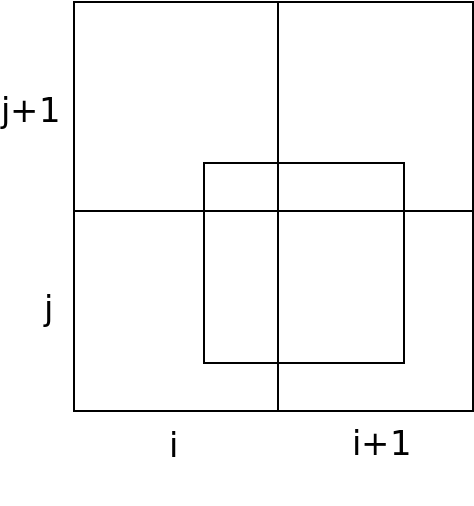

The lower-left corner of the offset box is the particle's position $\mathbf{r}_m$, and the indicies of lower-left grid cell are   
`i = floor(r[m,0]*M/L-0.5); j = floor(r[m,1]*M/L-0.5)`   
The indices of the upper-right cell are   
`ip = mod(i+1,M); jp = mod(j+1,M)`   
where the modulus function takes care of wrapping the particle's position in the periodic box.   
Writing   
`ux = r[m,0]*M/L -0.5 - i; uy = r[m,1]*M/L -0.5 - j`
Once the `u`'s are computed, we need to periodically "wrap" the `i` indices as well   
`i = int(i)%M; j = int(j)%M`   
The volume of the contribution to the grid cells are then   
`rho[ i, j] += (1-ux)*(1-uy)*mass[m]`   
`rho[ip, j] +=   ux  *(1-uy)*mass[m]`   
`rho[ i,jp] += (1-ux)*  uy  *mass[m]`   
`rho[ip,jp] +=   ux  *  uy  *mass[m]`   
After adding the contributions of all particles, to convert to a density
we must divide by the a cell's volume   
`rho[:,:,:] /= dx**2`   
to get a density in $L$ units.

Three dimensions are handled with an additional `k`,`kp`, and `uz`, and dividing by `dx**3`.

A simple implementation of cloud-in-cell assignment as 

In [299]:
def assign(pos, X, h, grid):
    """
    Assign X to grid using inverse of tri-linear (cloud-in-cell) interpolation
    pos[N,:], input: positions of N particles
    X[N], input: quantity to be assigned
    grid[M,M,M], input: grid on which to assign
    h, input: grid cell width
    """
    M = grid.shape[0]
    grid[:] = 0
    for m in range(pos.shape[0]):
        # cell index of lower-left corner of point's cube:
        ix, iy, iz = int(floor(pos[m,0]/h-0.5)), int(floor(pos[m,1]/h-0.5)), int(floor(pos[m,2]/h-0.5))
        # next index in each direction, "wrapping" for periodicity
        ixp, iyp, izp = (ix+1)%M, (iy+1)%M, (iz+1)%M 
        # fraction of cube in x,y,z in the next cell
        ux = (pos[m,0]/h - 0.5 - ix)
        uy = (pos[m,1]/h - 0.5 - iy)
        uz = (pos[m,2]/h - 0.5 - iz)
        # the lower-left indices as well (important to do this after finfing the u's)
        ix, iy, iz = ix%M, iy%M, iz%M

        # deposit particle's mass on grid
        grid[ix , iy , iz ] += (1-ux) * (1-uy) * (1-uz) * X[m]
        grid[ix , iy , izp] += (1-ux) * (1-uy) *   uz   * X[m]
        grid[ix , iyp, iz ] += (1-ux) *   uy   * (1-uz) * X[m]
        grid[ix , iyp, izp] += (1-ux) *   uy   *   uz   * X[m]
        grid[ixp, iy , iz ] +=   ux   * (1-uy) * (1-uz) * X[m]
        grid[ixp, iy , izp] +=   ux   * (1-uy) *   uz   * X[m]
        grid[ixp, iyp, iz ] +=   ux   *   uy   * (1-uz) * X[m]
        grid[ixp, iyp, izp] +=   ux   *   uy   *   uz   * X[m]

    # divide by cell volume
    grid /= h**3


***

The inverse of cloud-in-cell assignment is tri-linear interpolation. Using the same definitions of the cell indices and fractions, we have

In [310]:
def interpolate(grid, h, pos, X):
    """
    Interpolate from grid at pos onto X using tri-linear (cloud-in-cell) interpolation
    grid[M,M,M], input: grid from which to interpolate
    h, input: grid cell width
    pos[N,:], input: positions of N particles
    X[N], output: interpolated quantity
    """
    M = grid.shape[0]
    h3 = h**3
    X[:] = 0
    for m in range(pos.shape[0]):
        ix, iy, iz = int(floor(pos[m,0]/h-0.5)), int(floor(pos[m,1]/h-0.5)), int(floor(pos[m,2]/h-0.5))
        ixp, iyp, izp = (ix+1)%M, (iy+1)%M, (iz+1)%M 
        ux = (pos[m,0]/h - 0.5 - ix)
        uy = (pos[m,1]/h - 0.5 - iy)
        uz = (pos[m,2]/h - 0.5 - iz)
        ix, iy, iz = ix%M, iy%M, iz%M

        X[m] = (\
                    grid[ ix,  iy,  iz] * (1-ux) * (1-uy) * (1-uz) + \
                    grid[ ix,  iy, izp] * (1-ux) * (1-uy) *   uz   + \
                    grid[ ix, iyp,  iz] * (1-ux) *   uy   * (1-uz) + \
                    grid[ ix, iyp, izp] * (1-ux) *   uy   *   uz   + \
                    grid[ixp,  iy,  iz] *   ux   * (1-uy) * (1-uz) + \
                    grid[ixp,  iy, izp] *   ux   * (1-uy) *   uz   + \
                    grid[ixp, iyp,  iz] *   ux   *   uy   * (1-uz) + \
                    grid[ixp, iyp, izp] *   ux   *   uy   *   uz \
                  ) * h3

These are quite slow, relying on a `for` loop over all particles. Vectorizing using `numpy` would be
pretty complex, but there is an easier way... using the `numba` *just-in-time* (jit) compiler.
numpy.jit pre-compiles the code, making it much faster than plain, interpreted python. It also allows parallelism in loops by using the `prange` iterator instead of python's `range`.

The function will take a long time to execute the first time it is called as it is being compiled just in time. All subsequent calls will take much less time.

All we have done in the following is to include the `@jit` decorator before the function definition and
use `prange` for the loop over particles in `interpolateJIT`.

Note that we cannot use a parallel loop in `assignJIT` due to a *race condition*!

In [345]:
@jit(nopython=True)
def assignJIT(pos, X, h, grid):
    """
    Assign X to grid using inverse of tri-linear (cloud-in-cell) interpolation
    pos[N,:], input: positions of N particles
    X[N], input: quantity to be assigned
    grid[M,M,M], input: grid on which to assign
    h, input: grid cell width
    """
    M = grid.shape[0]
    grid[:] = 0
    
    # NB: loop cannot be parallelized due to race condition in grid[.] += lines
    for m in range(pos.shape[0]):
        # cell index of lower-left corner of point's cube:
        ix, iy, iz = int(floor(pos[m,0]/h-0.5)), int(floor(pos[m,1]/h-0.5)), int(floor(pos[m,2]/h-0.5))
        # next index in each direction
        ixp, iyp, izp = (ix+1)%M, (iy+1)%M, (iz+1)%M 
        # fraction of cube in x,y,z in the next cell
        ux = (pos[m,0]/h - 0.5 - ix)
        uy = (pos[m,1]/h - 0.5 - iy)
        uz = (pos[m,2]/h - 0.5 - iz)
        ix, iy, iz = ix%M, iy%M, iz%M

        # deposit particle's mass on grid
        grid[ix , iy , iz ] += (1-ux) * (1-uy) * (1-uz) * X[m]
        grid[ix , iy , izp] += (1-ux) * (1-uy) *   uz   * X[m]
        grid[ix , iyp, iz ] += (1-ux) *   uy   * (1-uz) * X[m]
        grid[ix , iyp, izp] += (1-ux) *   uy   *   uz   * X[m]
        grid[ixp, iy , iz ] +=   ux   * (1-uy) * (1-uz) * X[m]
        grid[ixp, iy , izp] +=   ux   * (1-uy) *   uz   * X[m]
        grid[ixp, iyp, iz ] +=   ux   *   uy   * (1-uz) * X[m]
        grid[ixp, iyp, izp] +=   ux   *   uy   *   uz   * X[m]

    # divide by cell volume
    grid /= h**3

    
@jit(nopython=True, parallel=True)
def interpolateJIT(grid, h, pos, X):
    """
    Interpolate from grid at pos onto X using tri-linear (cloud-in-cell) interpolation
    grid[M,M,M], input: grid from which to interpolate
    h, input: grid cell width
    pos[N,:], input: positions of N particles
    X[N], output: interpolated quantity
    """
    M = grid.shape[0]
    h3 = h**3
    X[:] = 0
    for m in prange(pos.shape[0]):
        ix, iy, iz = int(floor(pos[m,0]/h-0.5)), int(floor(pos[m,1]/h-0.5)), int(floor(pos[m,2]/h-0.5))
        ixp, iyp, izp = (ix+1)%M, (iy+1)%M, (iz+1)%M 
        ux = (pos[m,0]/h - 0.5 - ix)
        uy = (pos[m,1]/h - 0.5 - iy)
        uz = (pos[m,2]/h - 0.5 - iz)
        ix, iy, iz = ix%M, iy%M, iz%M

        X[m] = (\
                    grid[ ix,  iy,  iz] * (1-ux) * (1-uy) * (1-uz) + \
                    grid[ ix,  iy, izp] * (1-ux) * (1-uy) *   uz   + \
                    grid[ ix, iyp,  iz] * (1-ux) *   uy   * (1-uz) + \
                    grid[ ix, iyp, izp] * (1-ux) *   uy   *   uz   + \
                    grid[ixp,  iy,  iz] *   ux   * (1-uy) * (1-uz) + \
                    grid[ixp,  iy, izp] *   ux   * (1-uy) *   uz   + \
                    grid[ixp, iyp,  iz] *   ux   *   uy   * (1-uz) + \
                    grid[ixp, iyp, izp] *   ux   *   uy   *   uz \
                  ) * h3


Let's create some data and compare the three implementation's speed:

In [332]:
# Use an MxMxM grid
# create M^3 particles on [0,L]^3
M = 64
N = M**3
L = 10
h = L/M

# our particles and masses
pos = np.random.random(size=(N,3))*L
mass = np.ones(N)

In [333]:
# first the basic function
rhoPlain = np.zeros((M,M,M))
%timeit assign(pos, mass, h, rhoPlain)

1.95 s ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [343]:
# now the just-in-time function
rhoJIT = np.zeros((M,M,M))
assignJIT(pos, mass, h, rhoJIT)
%timeit assignJIT(pos, mass, h, rhoJIT)

9.47 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Clearly the compiled code is much faster! And much easier to write than vectorizing with numpy!

Numpy still has its uses; it makes writing linear algebra and finite-differences *much* easier, for example.
numba can compile numpy functions as well.

Let's check that the compiled code gets the same answer!

In [335]:
np.allclose(rhoJIT, rhoPlain, atol=1e-15, rtol=1e-15)

True

Do the same thing for `interpolate`. Of course, we will not get back our particle masses, since
many more than one particle contributed to density in each cell! We will, however, use this to interpolate
the acceleration at the particle's positions.

In [336]:
# first the basic function
fooPlain = np.zeros_like(mass)
%timeit interpolate(rhoPlain, h, pos, fooPlain)

1.95 s ± 49.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [346]:
# now the just-in-time function -- in parallel!
fooJIT = np.zeros_like(mass)
interpolateJIT(rhoPlain, h, pos, fooJIT)
%timeit interpolateJIT(rhoPlain, h, pos, fooJIT)

2.06 ms ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Roughly speaking, the parallel speedup was about a factor of five; not very good with twelve cores.
In C++ or Fortran, one would have much more control over parallelism and
would likely be able to do much better. We'll take the increased speed nonetheless!

In [338]:
np.allclose(rhoJIT, rhoPlain, atol=1e-15, rtol=1e-15)

True